In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{gensymb} \usepackage{siunitx}'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

### Loading the dataset

In [2]:
DATASET_PATH = '../datasets/hydroshoot_impulse.csv'

In [3]:
from src.model.rc_dataset import ExperimentDataset

dataset = ExperimentDataset(csv_path=DATASET_PATH)
print(dataset)

Dataset properties:
	n_runs:      33
	n_steps:    240
	state_size: 360

Available targets: 
	input_Tac, input_u, input_hs, input_Rg, output_Rg, output_An, output_E, output_Tleaf

Available state variables: 
	state_E, state_psi_head, state_An, state_Eabs, state_FluxC, state_Ci, state_u, state_Tlc, state_Flux, state_gs, state_gb, state_Ei, state_par_photo.dHd



### Figures

In [4]:
def nmse_distance(baseline, impulse):
  dist = np.empty(len(baseline))
  norm_factor = (baseline.var(axis=0) + 1e-12)
  for i_step in range(len(baseline)):
    base_state = baseline[i_step]
    state = impulse[i_step]
    dist[i_step] = ((base_state - state)**2 / norm_factor).mean()
  return dist


def get_data(run1, run2, state):
  # get raw data
  data1 = dataset.get_state(state, run1)[START:STOP]
  data2 = dataset.get_state(state, run2)[START:STOP]
  # remove NaN values
  NaN = np.isnan(data1)
  NaN_idx = np.any(NaN, axis=0)
  data1 = data1[:, ~NaN_idx]
  data2 = data2[:, ~NaN_idx]
  # calculate divergence between reservoir runs
  divergence = nmse_distance(data1, data2)
  return divergence

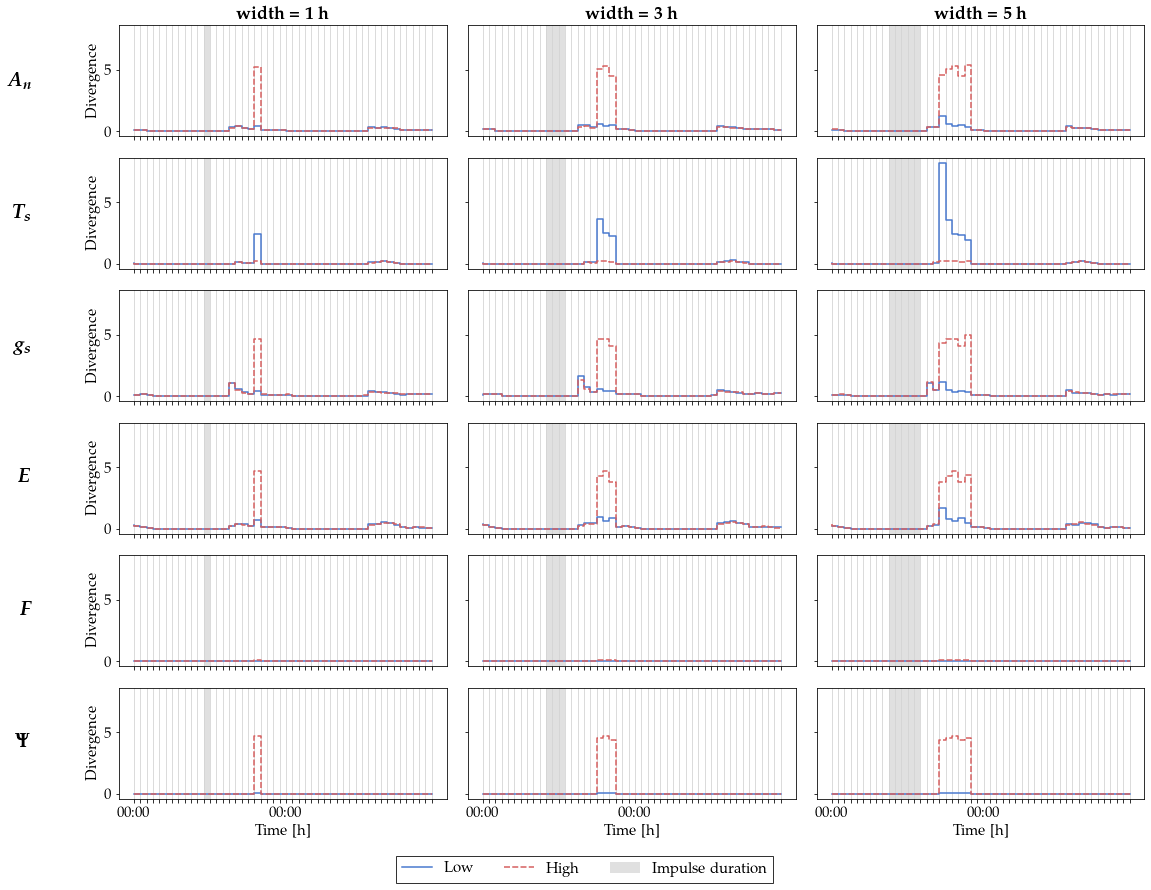

In [20]:
reservoirs = [
  'state_An',
  'state_Tlc',
  'state_gs',
  'state_E', 
  'state_Flux',
  'state_psi_head',
]

symbols = {
  'state_An': r'$A_n$',
  'state_Tlc': r'$T_s$',
  'state_gs': r'$g_s$',
  'state_E': r'$E$',
  'state_Flux': r'$F$',
  'state_psi_head': r'$\Psi$',
}

symbols_bold = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in symbols.items()}

widths = [1, 3, 5]

intervals = [
    (12, 13),  # width 1
    (11, 14),  # width 3
    (10, 15),  # width 5
 ]

baseline = '2012-08-19__width0__0'
template = lambda width, value: f'2012-08-19__width{width}__{value}'

START = 24 * 4
STOP = 24 * 6


def generate_xticklabels(xticks):
  labels = []
  for x in xticks:
    # if x % 24 == 0:
    #   labels.append(f'Day {x // 24 + 1}')
    if x % 24 < 10: 
      labels.append(f'0{x % 24}:00')
    else:
      labels.append(f'{x % 24}:00')
  return labels


with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(len(reservoirs), len(widths), figsize=(16, 12), sharex=True, sharey=True)
  colors = sns.color_palette()
  plot_colors = colors[0], colors[2]

  for row, (state, axs_row) in enumerate(zip(reservoirs, axs)):
    for col, (width, (p0, p1), ax) in enumerate(zip(widths, intervals, axs_row)):
      # get data
      pulse_lo = get_data(baseline, template(width, 0), state)
      pulse_hi = get_data(baseline, template(width, 1500), state)
      df = pd.DataFrame(pulse_lo, pulse_hi).reset_index()
      df.columns = ['Low', 'High']
      df.index = np.arange(START, STOP)

      # plot data
      sns.lineplot(data=df, ax=ax, palette=plot_colors, drawstyle='steps-pre')

      # color impulse steps
      ax.axvspan(4 * 24 + p0 - 1, 4 * 24 + p1 - 1, facecolor='0.2', alpha=0.15, label='Impulse duration')

      # x axis
      xticks = np.arange(START, STOP, 1)
      ax.set_xticks(xticks)
      xticklabels = generate_xticklabels(xticks)
      xticklabels = [label if not (i) % 24 else '' for i, label in enumerate(xticklabels)]
      ax.set_xticklabels(xticklabels)
      ax.grid(axis='x', linestyle='solid', color='lightgrey')

      # labeling
      ax.set_xlabel(r'Time [\unit{\hour}]')
      ax.set_ylabel(r'Divergence')

      if col == 0:
        ax.annotate(symbols_bold[state], (-0.27, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=20)

      if row == 0:
        ax.annotate(f'\\textbf{{width = {width} h}}', (0.5, 1.05), xycoords='axes fraction', ha='center', fontsize=18)

      # cleanup
      ax.get_legend().remove()
      if ax is axs[0][0]:
        fig.legend(loc='lower center', fancybox=False, shadow=False, ncol=5, 
                    frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.04), fontsize=15)
        
  
  plt.tight_layout()
  plt.savefig('impulse_reservoirs_hydroshoot.png', dpi=200, facecolor='white')


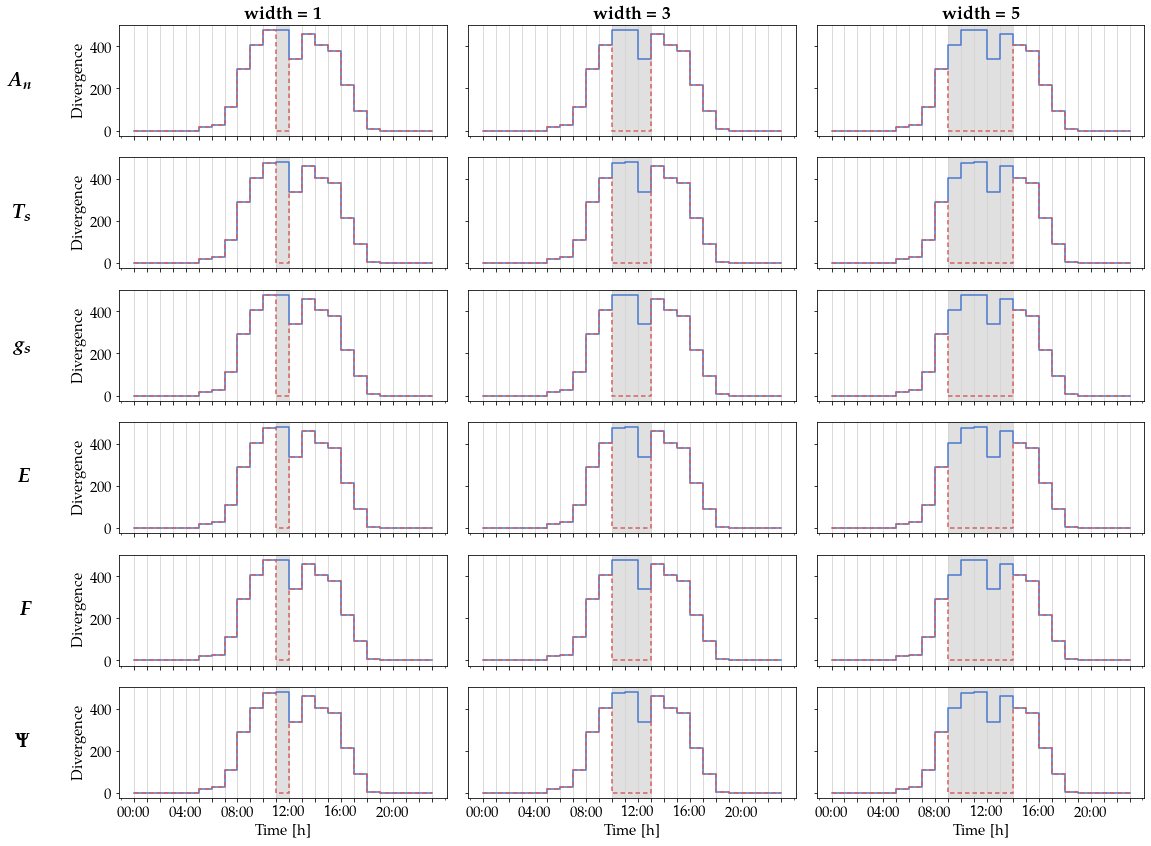

In [19]:
reservoirs = [
  'state_An',
  'state_Tlc',
  'state_gs',
  'state_E', 
  'state_Flux',
  'state_psi_head',
]

symbols = {
  'state_An': r'$A_n$',
  'state_Tlc': r'$T_s$',
  'state_gs': r'$g_s$',
  'state_E': r'$E$',
  'state_Flux': r'$F$',
  'state_psi_head': r'$\Psi$',
}

symbols_bold = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in symbols.items()}

widths = [1, 3, 5]

intervals = [
    (12, 13),  # width 1
    (11, 14),  # width 3
    (10, 15),  # width 5
 ]

baseline = '2012-08-19__width0__0'
template = lambda width, value: f'2012-08-19__width{width}__{value}'

START = 24 * 4
STOP = 24 * 5


def generate_xticklabels(xticks):
  labels = []
  for x in xticks:
    # if x % 24 == 0:
    #   labels.append(f'Day {x // 24 + 1}')
    if x % 24 < 10: 
      labels.append(f'0{x % 24}:00')
    else:
      labels.append(f'{x % 24}:00')
  return labels


with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(len(reservoirs), len(widths), figsize=(16, 12), sharex=True, sharey=True)
  colors = sns.color_palette()

  for row, (state, axs_row) in enumerate(zip(reservoirs, axs)):
    for col, (width, (p0, p1), ax) in enumerate(zip(widths, intervals, axs_row)):
      # get data
      base = dataset.get_target('input_Rg', baseline)[START:STOP]
      experiment = dataset.get_target('input_Rg', template(width, 0))[START:STOP]
      base.index = np.arange(START, STOP)
      experiment.index = np.arange(START, STOP)

      # plot data
      base.plot(ax=ax, label="Baseline", drawstyle='steps-pre', color=colors[0])
      experiment.plot(ax=ax, dashes=(3, 2), label="Impulse", drawstyle='steps-pre', color=colors[2])  

      # color impulse steps
      ax.axvspan(4 * 24 + p0 - 1, 4 * 24 + p1 - 1, facecolor='0.2', alpha=0.15)

      # x axis
      xticks = np.arange(START, STOP, 1)
      ax.set_xticks(xticks)
      xticklabels = generate_xticklabels(xticks)
      xticklabels = [label if not (i + 4) % 4 else '' for i, label in enumerate(xticklabels)]
      ax.set_xticklabels(xticklabels)
      ax.grid(axis='x', linestyle='solid', color='lightgrey')

      # labeling
      ax.set_xlabel(r'Time [\unit{\hour}]')
      ax.set_ylabel(r'Divergence')

      if col == 0:
        ax.annotate(symbols_bold[state], (-0.27, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=20)

      if row == 0:
        ax.annotate(f'\\textbf{{width = {width}}}', (0.5, 1.05), xycoords='axes fraction', ha='center', fontsize=18)


  plt.tight_layout()
  plt.savefig('impulse_inputs_cnwheat.png', dpi=200, facecolor='white')

